In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/kaggle/input/7emo-male-female/df_male_female_7emo.csv')
df.head()

,labels,source,path
0,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
1,male_fear,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
2,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
3,male_disgust,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
4,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...


In [3]:
df.shape

(12162, 3)

In [4]:
df['labels'].unique()

array(['male_happy', 'male_fear', 'male_disgust', 'male_angry',
       'male_surprise', 'male_neutral', 'male_sad', 'female_surprise',
       'female_neutral', 'female_disgust', 'female_fear', 'female_sad',
       'female_happy', 'female_angry'], dtype=object)

In [5]:
df[['gender', 'mood']] = df['labels'].str.split('_', expand=True)

In [6]:
df.head()

,labels,source,path,gender,mood
0,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
1,male_fear,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,male,fear
2,male_happy,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
3,male_disgust,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,male,disgust
4,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,male,angry


In [7]:
df = df.drop('labels', axis=1)

In [8]:
df.head()

,source,path,gender,mood
0,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
1,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,male,fear
2,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
3,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,male,disgust
4,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...,male,angry


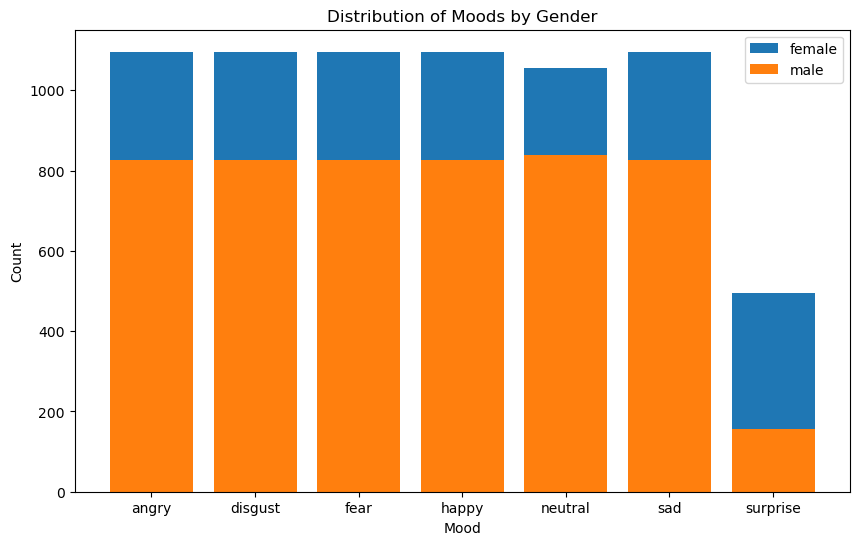

In [9]:
import matplotlib.pyplot as plt

# Count the occurrences of each combination of gender and mood
counts = df.groupby(['gender', 'mood']).size().reset_index(name='count')

# Create a bar plot
plt.figure(figsize=(10, 6))

# Group the data by gender
grouped_data = counts.groupby('gender')

# Iterate over each group and plot the bars
for gender, data in grouped_data:
    plt.bar(data['mood'], data['count'], label=gender)

plt.xlabel('Mood')
plt.ylabel('Count')
plt.title('Distribution of Moods by Gender')
plt.legend()
plt.show()

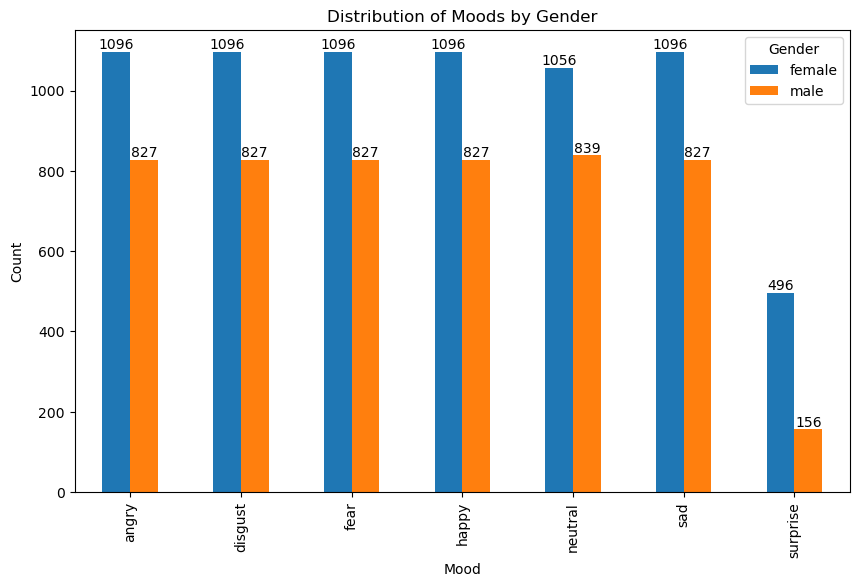

In [10]:
import matplotlib.pyplot as plt

# Assuming the DataFrame with the split columns is called 'df'

# Count the occurrences of each combination of gender and mood
counts = df.groupby(['mood', 'gender']).size().reset_index(name='count')

# Pivot the DataFrame to have genders as columns and moods as index
pivot_df = counts.pivot(index='mood', columns='gender', values='count')

# Create a bar chart
ax = pivot_df.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Mood')
plt.ylabel('Count')
plt.title('Distribution of Moods by Gender')
plt.legend(title='Gender')

# Add value labels to each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

# Processing

In [19]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    # Modify the implementation of the stretch function to fix the error
    # Call librosa.effects.time_stretch with only one argument
    
    stretched_data = librosa.effects.time_stretch(data, rate=0.8)
    return stretched_data

# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sample_rate):
    # Modify the implementation of the pitch function to fix the error
    # Call librosa.effects.pitch_shift with only one argument
    
    pitch_shifted_data = librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=2)
    return pitch_shifted_data

In [20]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_feat(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)  # Pass sample_rate argument here
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)  # Pass sample_rate argument here
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)  # Pass sample_rate argument here
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [21]:
from joblib import Parallel, delayed
import timeit

import librosa

In [22]:
import timeit

start = timeit.default_timer()

# Define a function to get features for a single audio file
def get_features(path, emotion):
    feature = get_feat(path)
    X, Y = [], []
    for ele in feature:
        X.append(ele)
        Y.append(emotion)
    return X, Y

# Call the get_features function in parallel for all audio files
X, Y = [], []
results = Parallel(n_jobs=-1)(delayed(get_features)(path, mood) for path, mood in zip(df['path'], df['mood']))

# Iterate over the results
for i, result in enumerate(results):
    iteration = i + 1
    print(f"Iteration {iteration} processing...")
    X.extend(result[0])
    Y.extend(result[1])

stop = timeit.default_timer()

print('Time: ', stop - start)

/opt/conda/lib/python3.10/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Iteration 1 processing...
Iteration 2 processing...
Iteration 3 processing...
Iteration 4 processing...
Iteration 5 processing...
Iteration 6 processing...
Iteration 7 processing...
Iteration 8 processing...
Iteration 9 processing...
Iteration 10 processing...
Iteration 11 processing...
Iteration 12 processing...
Iteration 13 processing...
Iteration 14 processing...
Iteration 15 processing...
Iteration 16 processing...
Iteration 17 processing...
Iteration 18 processing...
Iteration 19 processing...
Iteration 20 processing...
Iteration 21 processing...
Iteration 22 processing...
Iteration 23 processing...
Iteration 24 processing...
Iteration 25 processing...
Iteration 26 processing...
Iteration 27 processing...
Iteration 28 processing...
Iteration 29 processing...
Iteration 30 processing...
Iteration 31 processing...
Iteration 32 processing...
Iteration 33 processing...
Iteration 34 processing...
Iteration 35 processing...
Iteration 36 processing...
Iteration 37 processing...
Iteration 

# Save

In [23]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion_7emo.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,Emotions
0,0.036576,0.595285,0.518214,0.467623,0.385958,0.406441,0.428003,0.440104,0.408092,0.355243,...,6.810345e-06,9.494143e-07,1.276122e-07,5.920768e-08,6.259482e-08,6.776799e-08,9.807201e-08,7.782995e-08,3.130733e-08,happy
1,0.085992,0.649869,0.589771,0.549690,0.475963,0.474645,0.456577,0.452170,0.429342,0.410520,...,9.393524e-03,9.433108e-03,9.178484e-03,9.201945e-03,9.145651e-03,9.629839e-03,9.806825e-03,9.208133e-03,9.156841e-03,happy
2,0.046546,0.443668,0.527964,0.616520,0.523369,0.484113,0.385189,0.391395,0.420539,0.444481,...,4.920150e-05,2.178667e-05,1.077195e-05,5.347247e-06,1.774900e-06,3.389061e-07,3.680692e-08,7.171738e-09,6.988093e-10,happy
3,0.047286,0.534577,0.532759,0.547124,0.471091,0.469727,0.530667,0.520320,0.515186,0.549633,...,3.483586e-08,1.314616e-08,7.895075e-09,7.103722e-09,7.353459e-09,6.959937e-09,6.308861e-09,3.876357e-09,4.155905e-10,fear
4,0.089084,0.606321,0.615064,0.636389,0.623361,0.580148,0.600636,0.583029,0.555048,0.559653,...,4.526048e-05,4.610493e-05,4.488770e-05,4.359153e-05,4.542908e-05,4.248062e-05,4.320024e-05,4.537527e-05,4.524543e-05,fear


In [ ]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()